In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import yaml
import seaborn as sns
import spacy
import math
from wordfreq import word_frequency
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import spacy
from collections import Counter

def load_yaml(fname):
    with open(fname, 'r') as stream:
        try:
            f = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
            sys.exit(1)
    return f

settings = load_yaml("../settings.yaml")

In [2]:
table = []
for path, subfolder, files in os.walk('.'):
    for name in files:
        if any(x in name for x in ['stats-1563815144.json', 
                                   'stats-1563821759.json', 
                                   'stats-1563669515.json', 
                                   'stats-1563876157.json', 
                                   'stats-1563921802.json']):
            print(name)
            try:
                rows = json.load(open(name, 'r'))
                for row in rows:
                    row['test']
                    #assert('_./' in row['test'])
                table.extend([x for x in rows if x not in table])
            except:
                pass

stats-1563669515.json
stats-1563921802.json
stats-1563876157.json
stats-1563815144.json
stats-1563821759.json


In [48]:
df = pd.DataFrame(table)
df[df['test'] == 'ELMo'].sort_values(by='MSE')

,MSE,lang,pearson,test
0,0.497809,ptbr,0.587910,ELMo
1,0.786156,pteu,0.593352,ELMo


In [91]:
stds = 1.0
df = pd.DataFrame(table)
df = df[df['test'].str.contains('_./')].round(2)
df['model1'] = df['test'].apply(lambda x: x.split('_./')[0])
df['model2'] = df['test'].apply(lambda x: x.split('/')[-2])
df['model3'] = df['test'].apply(lambda x: x.split('/')[-1].split('_')[-2])
df['size'] = df['test'].apply(lambda x: x.split('/')[-1].rstrip('.model').split('_s')[-1])
df = df[df['model1'].isin(['ELMo', 'NILC', 'ELMo_NILC'])]
df = df[['lang', 'model1', 'model2', 'model3', 'size', 'MSE', 'pearson']]

x = df.sort_values(by=['lang', 'model1', 'model2', 'model3', 'size'])\
.groupby(by=['lang', 'model1', 'size'])\
.transform(lambda group: (group - group.mean()).div(group.std())).abs() > stds

MSE_outliers = list(x[x['MSE']==True].index)

pearson_outliers = list(x[x['pearson']==True].index)

df['index'] = df.index

lst = df.values.tolist()
for item in lst:
    idx = item[-1]
    pearson = item[-2]
    MSE = item[-3]
    if idx in MSE_outliers:
        item[-3] = "\\textbf{%s}" % str(MSE)
    if idx in pearson_outliers:
        item[-2] = "\\textbf{%s}" % str(pearson)

y = pd.DataFrame(lst)
y[4] = y[4].astype(int)
y.sort_values(by=[0,1,2,3,4]).to_csv('result.csv')

In [4]:
def plot_model(table, name, title, lang='ptbr'):
    df = pd.DataFrame(table)
    df["model"] = df["test"].apply(lambda x: x.split("_./")[0])
    df["name"] = df["test"].apply(lambda x: '/'.join(x.split('/')[3:]).rstrip('.model'))
    df = df[["model", "name", "MSE", "pearson", "lang"]]
    
    params = {
    "model": ['NILC', 'ELMo_NILC'],
    "lang": [lang]
    }

    for key in params.keys():
        df = df[df[key].isin(params[key])]
    for n in name:
        df = df[df['name'].str.contains(n)]
    df['name'] = df['name'].apply(lambda x: x.split('_s')[-1])
    df["model"] = df["model"].apply(lambda x: params["model"].index(x) + 1)
    df = df.astype({"name": int})
    df = df.sort_values(by='name')
    df = df.astype({"name": str})
    sizes = df['name'].tolist()
    sizes = [ v for i,v in enumerate(sizes) if sizes.index(v) == i]

    df['name'] = df['name'].astype(int)
    df = df.rename(columns={'name': 'size'})
    df = df.rename(columns={'model': 'emb'})
    df['model'] = title
    return list(df.T.to_dict().values())

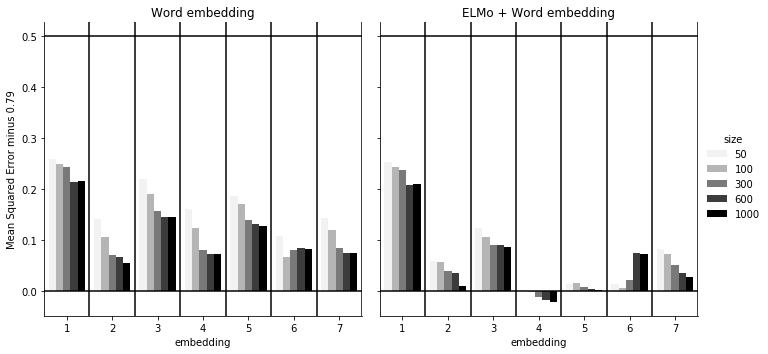

In [50]:
%matplotlib inline 

input_args = [(['fasttext', 'cbow'], 1), #'Fast-sg'
              (['fasttext', 'skip'], 2), 
              (['glove'], 3),
              (['word2vec', 'cbow'], 4),
              (['word2vec', 'skip'], 5),
              (['wang2vec', 'cbow'], 6),
              (['wang2vec', 'skip'], 7)
             ]
LANG = 'pteu'
VALUE = 'MSE'
w = df[df['test'] == 'ELMo']
w = w[w['lang']==LANG]
w = w[VALUE].values.tolist()[0]

SCALE = w
LABEL = "Mean Squared Error minus {0}".format(str(round(w, 2)))

FNAME = 'MSE_all_pteu.png'

lst = []
for i,v in enumerate(input_args):
    lst += plot_model(table, lang=LANG, *v)
    
dataplot = pd.DataFrame(lst)

dataplot[VALUE] = dataplot[VALUE].apply(lambda x: x - SCALE)

dataplot = dataplot.sort_values(by=['model', 'emb', 'size'])\
.rename(columns={'model': 'embedding'})

g = sns.catplot(x='embedding', 
                y=VALUE, 
                hue='size', 
                col='emb', 
                kind='bar', 
                col_wrap=2, 
                color='black',
                data=dataplot,
                legend_out = True)

names = [ 'Word embedding', 
         'ELMo + Word embedding']
for idx,ax in enumerate(g.axes):
    ax.axhline(0.0, color='black')
    ax.set_title(names[idx])
    for i in range(len(input_args)):
        ax.axvline(x=0.5+i, color='black')
        if not idx:
            ax.set(ylabel=LABEL)
    ax.axhline(y=0.5, color='black')
            
g.savefig(FNAME)

In [104]:
log = []
for path, subfolder, files in os.walk('.'):
    for fname in files:
        if fname.startswith('stats'):
            try:
                log.extend(json.load(open(fname,'r')))
            except:
                pass

NILCSIF = []
ELMo_NILCSIF = []

for entry in log:
    match = ""
    try:
        match = entry['test']
    except:
        continue
    if "ELMo_NILC-SIF" in match:
        entry['test'] = "/".join(entry['test'].split('/')[3:]).rstrip('.model')
        ELMo_NILCSIF.append(entry)
    elif 'NILC-SIF' in match:
        entry['test'] = "/".join(entry['test'].split('/')[3:]).rstrip('.model')
        NILCSIF.append(entry)

df1 = pd.DataFrame(ELMo_NILCSIF)
df2 = pd.DataFrame(NILCSIF)
df1 = df1.rename(columns={
    "MSE": "ELMO_NILCSIF_MSE",
    "pearson": "ELMO_NILCSIF_pearson"
})
df2 = df2.rename(columns={
  "MSE": "NILCSIF_MSE",
    "pearson": "NILCSIF_pearson"
})

df = pd.merge(df1, df2, how="outer")
df['diff'] = df['ELMO_NILCSIF_MSE'].sub(df['NILCSIF_MSE'], axis=0)
df[df['lang'] == 'ptbr'].sort_values(by='diff')

df

,ELMO_NILCSIF_MSE,lang,ELMO_NILCSIF_pearson,test,NILCSIF_MSE,NILCSIF_pearson,diff
0,0.540914,ptbr,0.536856,glove/glove_s50,0.589787,0.473356,-0.048874
1,0.540914,ptbr,0.536856,glove/glove_s50,0.536387,0.542328,0.004527
2,0.799591,pteu,0.588576,glove/glove_s50,0.957751,0.455081,-0.158160
3,0.799591,pteu,0.588576,glove/glove_s50,0.807418,0.585605,-0.007828
4,0.539336,ptbr,0.538777,glove/glove_s300,0.536259,0.543422,0.003077
5,0.539336,ptbr,0.538777,glove/glove_s300,0.534996,0.544008,0.004340
6,0.798129,pteu,0.590016,glove/glove_s300,0.897287,0.520771,-0.099158
7,0.798129,pteu,0.590016,glove/glove_s300,0.806109,0.586918,-0.007980
8,0.538402,ptbr,0.539912,glove/glove_s600,0.525532,0.556624,0.012870
9,0.538402,ptbr,0.539912,glove/glove_s600,0.534153,0.545025,0.004249


In [105]:
log = []
for path, subfolder, files in os.walk('.'):
    for fname in files:
        if fname.startswith('stats'):
            try:
                log.extend(json.load(open(fname,'r')))
            except:
                pass

NILCSIF = []
NILC = []

NILC_seen = []
NILCSIF_seen = []
for entry in log:
    match = ""
    try:
        match = entry['test']
    except:
        continue
    if match.startswith('NILC-SIF_'):
        if entry['test'] in NILCSIF_seen:
            continue
        NILCSIF_seen.append(entry['test'])
        entry['test'] = "/".join(entry['test'].split('/')[3:]).rstrip('.model')
        NILCSIF.append(entry)
        
    elif match.startswith('NILC_'):
        if entry['test'] in NILC_seen:
            continue
        NILC_seen.append(entry['test'])
        entry['test'] = "/".join(entry['test'].split('/')[3:]).rstrip('.model')
        NILC.append(entry)

df1 = pd.DataFrame(NILCSIF)
df2 = pd.DataFrame(NILC)
df1 = df1.rename(columns={
    "MSE": "NILCSIF_MSE",
    "pearson": "NILCSIF_pearson"
})
df2 = df2.rename(columns={
  "MSE": "NILC_MSE",
    "pearson": "NILC_pearson"
})

df3 = pd.merge(df1, df2, how="outer")
df3['diff'] = df3['NILCSIF_MSE'].sub(df3['NILC_MSE'], axis=0)
df3[df3['lang'] == 'ptbr'].sort_values(by='diff')

df3.sort_values(by=['MSE', 'pearson'])

,NILCSIF_MSE,lang,NILCSIF_pearson,test,NILC_MSE,NILC_pearson,diff
0,0.589787,ptbr,0.473356,glove/glove_s50,0.623054,0.425599,-0.033267
1,0.589787,ptbr,0.473356,glove/glove_s50,0.624651,0.422802,-0.034864
2,0.536259,ptbr,0.543422,glove/glove_s300,0.578580,0.490330,-0.042321
3,0.536259,ptbr,0.543422,glove/glove_s300,0.579109,0.489486,-0.042850
4,0.525532,ptbr,0.556624,glove/glove_s600,0.564317,0.509656,-0.038785
5,0.525532,ptbr,0.556624,glove/glove_s600,0.568164,0.504465,-0.042632
6,0.523251,ptbr,0.559367,glove/glove_s1000,0.557965,0.517909,-0.034714
7,0.523251,ptbr,0.559367,glove/glove_s1000,0.560799,0.513977,-0.037548
8,0.564805,ptbr,0.507086,glove/glove_s100,0.603320,0.455270,-0.038515
9,0.564805,ptbr,0.507086,glove/glove_s100,0.604151,0.453889,-0.039346


In [113]:
model_df = df[df['test'].str.contains("fasttext")]
model_df = model_df[model_df['lang'].str.contains("ptbr")]
model_df3 = df3[df3['test'].str.contains("fasttext")]
model_df3 = model_df3[model_df3['lang'].str.contains("ptbr")]

model_df['step'] = 1
model_df3['step'] = 2
model_df = model_df[['diff', 'step', 'test']]
model_df3 = model_df3[['diff', 'step', 'test']]
joint_df = pd.concat([model_df, model_df3], axis=0)
joint_df

#diff = joint_df[['test', 'diff','step']]
#diff

,diff,step,test
54,-0.078080,1,fasttext/cbow_s100
56,0.010306,1,fasttext/skip_s300
58,-0.065672,1,fasttext/cbow_s600
60,0.024732,1,fasttext/skip_s1000
62,-0.064321,1,fasttext/cbow_s1000
64,-0.087096,1,fasttext/cbow_s50
66,-0.040136,1,fasttext/skip_s50
68,-0.014375,1,fasttext/skip_s100
70,0.017474,1,fasttext/skip_s600
72,-0.069877,1,fasttext/cbow_s300


In [10]:
with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2],
        'pteu-pearson-2017': line[3],
        'pteu-MSE-2017': line[4]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df2017

,model,ptbr-MSE-2017,ptbr-pearson-2017,pteu-MSE-2017,pteu-pearson-2017
0,fasttext_cbow_s50,0.66,0.36,1.05,0.34
1,fasttext_cbow_s100,0.66,0.37,1.04,0.36
2,fasttext_cbow_s300,0.65,0.38,1.03,0.37
3,fasttext_cbow_s600,0.68,0.33,1.02,0.38
4,fasttext_cbow_s1000,0.64,0.39,0.99,0.41
5,fasttext_skip_s50,0.61,0.45,0.98,0.43
6,fasttext_skip_s100,0.58,0.49,0.94,0.47
7,fasttext_skip_s300,0.53,0.55,1.02,0.40
8,fasttext_skip_s600,0.64,0.40,1.01,0.40
9,fasttext_skip_s1000,0.56,0.52,0.86,0.54


In [11]:
df2019_no_elmo = df2019[df2019.model != 'ELMo']
df = pd.merge(df2017, df2019_no_elmo, how='outer', on='model')
df = df.drop(['pteu-MSE-2017', 'pteu-pearson-2017'], axis=1)
df = df.rename(columns={"MSE": "ptbr-MSE-2019", "pearson": "ptbr-pearson-2019"})

cols = df.columns.tolist()
cols = [cols[1], cols[3]]
tmp = df[cols]
df['diff'] = pd.to_numeric(df['ptbr-MSE-2017']).sub(df['ptbr-MSE-2019'], axis=0)

mean = df['diff'].values.astype(float).mean()
Q1 = df['diff'].quantile(0.25)
Q3 = df['diff'].quantile(0.75)
IQR = Q3 - Q1

elmo_row = df2019[df2019['model'] == 'ELMo'].to_dict()
elmo = {}
elmo['ptbr-MSE-2019'] = elmo_row['MSE'][0]
elmo['ptbr-pearson-2019'] = elmo_row['pearson'][0]
elmo['model'] = 'ELMo'
df = df.append(elmo, ignore_index=True)

def highlight_outliers(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return [attr if v else '' for v in is_out]
    else: 
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return pd.DataFrame(np.where(is_out, attr, ''),
                            index=data.index, columns=data.columns)
   
style_df = df.style.apply(highlight_outliers, color='darkorange', axis=None, subset=['diff'])

In [20]:
df = df.sort_values(by='ptbr-MSE-2019')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_ptbr-MSE-2019.xlsx")
style_df

,model,ptbr-MSE-2017,ptbr-pearson-2017,ptbr-MSE-2019,ptbr-pearson-2019,diff
9,fasttext_skip_s1000,0.56,0.52,0.491466,0.595615,0.0685345
19,wang2vec_skip_s1000,0.49,0.60,0.492201,0.594679,-0.00220142
8,fasttext_skip_s600,0.64,0.40,0.49444,0.591606,0.14556
18,wang2vec_skip_s600,0.49,0.59,0.497738,0.588351,-0.00773769
35,ELMo,nan,nan,0.497809,0.58791,nan
7,fasttext_skip_s300,0.53,0.55,0.500397,0.58479,0.0296034
29,word2vec_cbow_s1000,0.50,0.58,0.504838,0.581221,-0.00483789
17,wang2vec_skip_s300,0.50,0.58,0.507129,0.577544,-0.00712893
12,wang2vec_cbow_s300,0.55,0.53,0.507934,0.577094,0.0420665
28,word2vec_cbow_s600,0.51,0.57,0.511869,0.572974,-0.00186933


In [21]:
df = df.sort_values(by='model')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_model-MSE-2019.xlsx")
style_df

,model,ptbr-MSE-2017,ptbr-pearson-2017,ptbr-MSE-2019,ptbr-pearson-2019,diff
35,ELMo,nan,nan,0.497809,0.58791,nan
1,fasttext_cbow_s100,0.66,0.37,0.659786,0.363861,0.000213743
4,fasttext_cbow_s1000,0.64,0.39,0.638319,0.401842,0.00168077
2,fasttext_cbow_s300,0.65,0.38,0.65367,0.37477,-0.00367048
0,fasttext_cbow_s50,0.66,0.36,0.667274,0.350017,-0.00727383
3,fasttext_cbow_s600,0.68,0.33,0.636966,0.404073,0.0430341
6,fasttext_skip_s100,0.58,0.49,0.5287,0.551922,0.0513003
9,fasttext_skip_s1000,0.56,0.52,0.491466,0.595615,0.0685345
7,fasttext_skip_s300,0.53,0.55,0.500397,0.58479,0.0296034
5,fasttext_skip_s50,0.61,0.45,0.554217,0.520344,0.0557829


In [4]:
with open('stats-1563548742.json','r') as f:
    table = json.load(f)
    
df2019 = pd.DataFrame(table)

df2019.sort_values(by='MSE')

,MSE,model,pearson
0,0.786156,ELMo,0.593352
19,0.840753,fasttext_skip_s1000,0.551524
24,0.852692,fasttext_skip_s600,0.539204
6,0.853027,wang2vec_cbow_s100,0.537986
17,0.856891,fasttext_skip_s300,0.536300
28,0.859121,word2vec_cbow_s600,0.546623
30,0.859500,word2vec_cbow_s1000,0.546932
14,0.860323,wang2vec_skip_s600,0.531198
9,0.861463,wang2vec_skip_s1000,0.533686
15,0.866916,wang2vec_cbow_s300,0.526741


In [5]:
with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2],
        'pteu-pearson-2017': line[3],
        'pteu-MSE-2017': line[4]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df2017

,model,ptbr-MSE-2017,ptbr-pearson-2017,pteu-MSE-2017,pteu-pearson-2017
0,fasttext_cbow_s50,0.66,0.36,1.05,0.34
1,fasttext_cbow_s100,0.66,0.37,1.04,0.36
2,fasttext_cbow_s300,0.65,0.38,1.03,0.37
3,fasttext_cbow_s600,0.68,0.33,1.02,0.38
4,fasttext_cbow_s1000,0.64,0.39,0.99,0.41
5,fasttext_skip_s50,0.61,0.45,0.98,0.43
6,fasttext_skip_s100,0.58,0.49,0.94,0.47
7,fasttext_skip_s300,0.53,0.55,1.02,0.40
8,fasttext_skip_s600,0.64,0.40,1.01,0.40
9,fasttext_skip_s1000,0.56,0.52,0.86,0.54


In [6]:
df2019_no_elmo = df2019[df2019.model != 'ELMo']
df = pd.merge(df2017, df2019_no_elmo, how='outer', on='model')
df = df.drop(['ptbr-MSE-2017', 'ptbr-pearson-2017'], axis=1)
df = df.rename(columns={"MSE": "pteu-MSE-2019", "pearson": "pteu-pearson-2019"})

cols = df.columns.tolist()
cols = [cols[1], cols[3]]
tmp = df[cols]
df['diff'] = pd.to_numeric(df['pteu-MSE-2017']).sub(df['pteu-MSE-2019'], axis=0)

mean = df['diff'].values.astype(float).mean()
Q1 = df['diff'].quantile(0.25)
Q3 = df['diff'].quantile(0.75)
IQR = Q3 - Q1

elmo_row = df2019[df2019['model'] == 'ELMo'].to_dict()
elmo = {}
elmo['pteu-MSE-2019'] = elmo_row['MSE'][0]
elmo['pteu-pearson-2019'] = elmo_row['pearson'][0]
elmo['model'] = 'ELMo'
df = df.append(elmo, ignore_index=True)

def highlight_outliers(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return [attr if v else '' for v in is_out]
    else: 
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return pd.DataFrame(np.where(is_out, attr, ''),
                            index=data.index, columns=data.columns)
   
style_df = df.style.apply(highlight_outliers, color='darkorange', axis=None, subset=['diff'])

In [8]:
df = df.sort_values(by='pteu-MSE-2019')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_pteu-MSE-2019.xlsx")
style_df

,model,pteu-MSE-2017,pteu-pearson-2017,pteu-MSE-2019,pteu-pearson-2019,diff
35,ELMo,nan,nan,0.786156,0.593352,nan
9,fasttext_skip_s1000,0.86,0.54,0.840753,0.551524,0.0192468
8,fasttext_skip_s600,1.01,0.40,0.852692,0.539204,0.157308
11,wang2vec_cbow_s100,0.85,0.54,0.853027,0.537986,-0.00302675
7,fasttext_skip_s300,1.02,0.40,0.856891,0.5363,0.163109
28,word2vec_cbow_s600,0.86,0.55,0.859121,0.546623,0.000879339
29,word2vec_cbow_s1000,0.86,0.55,0.8595,0.546932,0.000499534
18,wang2vec_skip_s600,0.83,0.54,0.860323,0.531198,-0.0303232
19,wang2vec_skip_s1000,0.85,0.54,0.861463,0.533686,-0.0114633
12,wang2vec_cbow_s300,0.89,0.51,0.866916,0.526741,0.0230843


In [9]:
df = df.sort_values(by='model')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_model-pteu-MSE-2019.xlsx")
style_df

,model,pteu-MSE-2017,pteu-pearson-2017,pteu-MSE-2019,pteu-pearson-2019,diff
35,ELMo,nan,nan,0.786156,0.593352,nan
1,fasttext_cbow_s100,1.04,0.36,1.03562,0.352073,0.00438114
4,fasttext_cbow_s1000,0.99,0.41,1.00242,0.390162,-0.0124165
2,fasttext_cbow_s300,1.03,0.37,1.02894,0.361131,0.00105744
0,fasttext_cbow_s50,1.05,0.34,1.04468,0.340293,0.00531521
3,fasttext_cbow_s600,1.02,0.38,1.00029,0.392895,0.0197121
6,fasttext_skip_s100,0.94,0.47,0.893179,0.500578,0.0468213
9,fasttext_skip_s1000,0.86,0.54,0.840753,0.551524,0.0192468
7,fasttext_skip_s300,1.02,0.40,0.856891,0.5363,0.163109
5,fasttext_skip_s50,0.98,0.43,0.927153,0.471378,0.0528472


In [5]:
with open('stats-1563565586.json','r') as f:
    table = json.load(f)
    
df = pd.DataFrame(table)

df['diff'] = 0.497809 - df['MSE']

df.sort_values(by='diff')

,MSE,model,pearson,diff
20,0.527335,ELMo_fasttext_cbow_s50,0.554381,-0.029526
15,0.525939,ELMo_fasttext_cbow_s100,0.555947,-0.028130
24,0.524342,ELMo_fasttext_cbow_s300,0.557842,-0.026533
19,0.516174,ELMo_fasttext_cbow_s1000,0.567654,-0.018365
17,0.516074,ELMo_fasttext_cbow_s600,0.567756,-0.018265
31,0.497767,ELMo_word2vec_skip_s50,0.587955,0.000042
30,0.497720,ELMo_word2vec_cbow_s50,0.588010,0.000089
32,0.497710,ELMo_word2vec_skip_s100,0.588018,0.000099
25,0.497644,ELMo_word2vec_cbow_s100,0.588096,0.000165
10,0.497615,ELMo_wang2vec_cbow_s50,0.588126,0.000194


In [10]:
with open('stats-1563570740.json','r') as f:
    table = json.load(f)
    
df = pd.DataFrame(table)

df = df.rename(columns={"MSE": "MSE-ptbr-2019-unk", "pearson": "pearson-ptbr-2019-unk"})

with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df = df2017.merge(df, on='model')
df = df.sort_values(by='MSE-ptbr-2019-unk')
df.to_csv('sentence_similarity_sorted_by_model_with_unk-ptbr-MSE-2019', index=False)
df

,model,ptbr-MSE-2017,ptbr-pearson-2017,MSE-ptbr-2019-unk,pearson-ptbr-2019-unk
19,wang2vec_skip_s1000,0.49,0.60,0.489663,0.597950
18,wang2vec_skip_s600,0.49,0.59,0.495136,0.591881
29,word2vec_cbow_s1000,0.50,0.58,0.504631,0.581436
17,wang2vec_skip_s300,0.50,0.58,0.505104,0.580379
12,wang2vec_cbow_s300,0.55,0.53,0.507232,0.578423
28,word2vec_cbow_s600,0.51,0.57,0.511837,0.573002
11,wang2vec_cbow_s100,0.52,0.56,0.519220,0.562851
27,word2vec_cbow_s300,0.53,0.55,0.529743,0.551951
16,wang2vec_skip_s100,0.54,0.54,0.537701,0.541850
34,word2vec_skip_s1000,0.54,0.54,0.538644,0.541569


In [99]:
from similarity import Loader, Regression, Embedding, CombinedEmbedding
from distance import flair_distance, gensim_distance, combined_distance
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from flair.embeddings import ELMoEmbeddings
import json
from loguru import logger
import yaml
import sys
import os
import datetime
from sklearn.manifold import TSNE
from collections import defaultdict

os.chdir('..')

settings = {}
with open("settings.yaml", 'r') as stream:
    try:
        settings = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        sys.exit(1)
        
EMBEDDINGS_DIR = settings['NILC']['dir']

result = []
for path, subdirs, files in os.walk(EMBEDDINGS_DIR):
    for name in files:
        dst = path + '/' + name
        if name.endswith('.model'):
            embedding = KeyedVectors.load(dst)
            result.append(embedding.most_similar('unk'))

In [123]:
labels = []
for path, subdirs, files in os.walk(EMBEDDINGS_DIR):
    for name in files:
        dst = path + '/' + name
        if name.endswith('.model'):
            label = path.split('/')[-1] + '_' + name.rstrip('.model')
            labels.append(label)

rows = []
cols = [ [x[0] for x in y ] for y in result]
for entry in range(len(cols[0])):
    row = {}
    for idx,item in enumerate(cols):
        row[labels[idx]] = cols[idx].pop(0)
    rows.append(row)

In [127]:
df = pd.DataFrame(rows)
df.to_csv('the_unk_bug.csv', index=False)
df

,fasttext_cbow_s100,fasttext_cbow_s1000,fasttext_cbow_s300,fasttext_cbow_s50,fasttext_cbow_s600,fasttext_skip_s100,fasttext_skip_s1000,fasttext_skip_s300,fasttext_skip_s50,fasttext_skip_s600,...,word2vec_cbow_s100,word2vec_cbow_s1000,word2vec_cbow_s300,word2vec_cbow_s50,word2vec_cbow_s600,word2vec_skip_s100,word2vec_skip_s1000,word2vec_skip_s300,word2vec_skip_s50,word2vec_skip_s600
0,slunk,sunk,slunk,g-funk,grunk,sexfunk,gunk,gunk,painkiller,gunk,...,disfunã§ã£o,lemniscata,mundo-0000,adels,mundo-0000,dresta,inexplicable,chiii,objection,chiii
1,g-funk,gunk,grunk,spunk,slunk,goddamned,sunk,sexfunk,afterlife,sexfunk,...,"0:0,00",estarrecer,lmkv,crupo,consp,dixanadu,awolnation,shasha,ji-sub,genteel
2,synthpunk,grunk,g-funk,b-rock,cowpunk,bloodpop,tunk,unkle,flaming,sunk,...,groaning,bollebygd,u.s.o,cafil,onemba,begotten,attacking,kibou,magiam,whatta
3,cowpunk,slunk,p-funk,grunk,spunk,blinking,sexfunk,underdunk,bloodpop,crunk,...,000hab,cesf,cãºmulo,agarrador,climatério,tonik,weaker,coelis,beethoven's,repent
4,grunk,spunk,crunk,slunk,punk-funk,bloodied,pop/punk,spunk,hiphoprisy,tunk,...,realvideo,jelincic,gaivota-tridáctila,não-dador,kālidāsa,wetting,discern,hyperbole,refrigerator,(sem
5,g-punk,crunk,spunk,0beat,crunk,unkle,crunk,crunk,unknow,slunk,...,gingko,ostrołęcki,substantividade,huffpo,lmkv,devlins,strides,mockery,yagni,transmigration
6,crunk,cowpunk,cowpunk,synthpunk,gunk,bollocks,slunk,unknowns,goddamned,unkle,...,mesmo000,perder-te,consp,snappamatic,anti-banner,horrorpops,betray,cmon,crazy/beautiful,attacking
7,spunk,punk-funk,underdunk,cowpunk,g-funk,truth,punk-funk,unknow,sideonedummy,punk-funk,...,brainer,atencipação,zugerberg,parecer0,d.p.r,swarthout,turpentine,nirou,candleford,homeboys
8,punk-funk,g-punk,g-punk,unkind,underdunk,undergound,g-punk,dance-punk,hearty,spunk,...,pã³quer,qazakh,fiestar,stormer,molinologia,guirlande,impatience,cyclists,elopement,portrayed
9,unkle,hunk,punk-funk,war-rock,p-funk,screaming,spunk,pop-punk,psychotic,pop/punk,...,neithhotep,anfpc,idiota-prodígio,mysticismo,finição,pikul,deceived,propellerheads,what(ever,cyclists


explained variance ratio (first two components): [0.92461872 0.05306648]


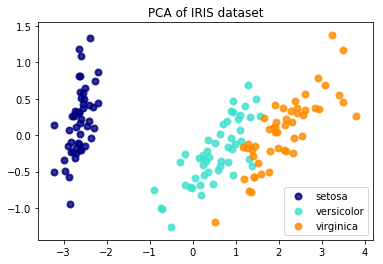

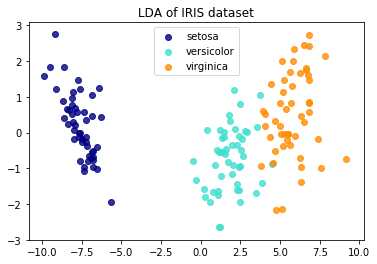

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()